In [1]:
import numpy as np

np.random.seed(42)

# Question 1

In [2]:
from keras.datasets import fashion_mnist

2025-03-10 01:05:58.299591: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
np.amin(train_labels), np.amax(train_labels)

(0, 9)

In [5]:
import matplotlib.pyplot as plt

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
def plot_images(images, labels):
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[np.random.choice(np.where(labels==i)[0])], cmap='gray')
        plt.title(class_names[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

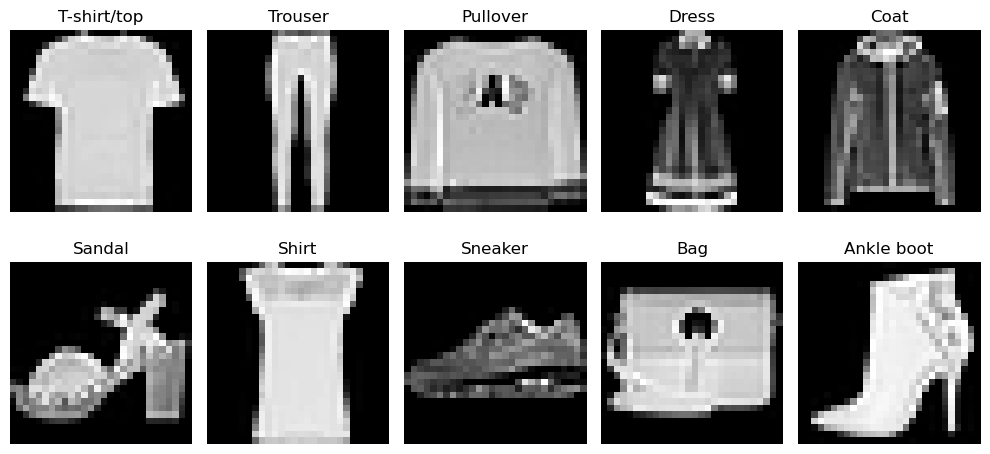

In [8]:
plot_images(train_images, train_labels)

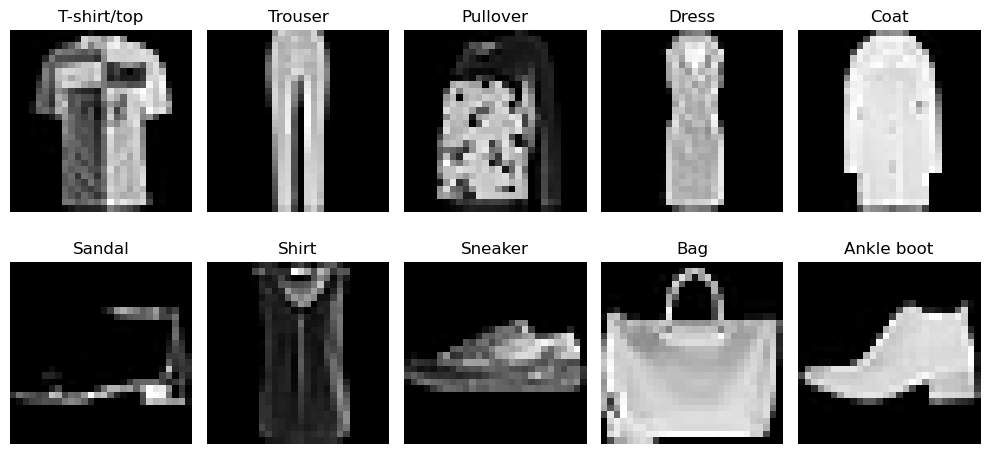

In [9]:
plot_images(test_images, test_labels)

# Question 2

In [10]:
class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.weights = [np.random.randn(y, x) * np.sqrt(2/x) for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((y,)) for y in layer_sizes[1:]]
    
    def relu(self, A):
        return np.maximum(0, A)
    
    def softmax(self, A):
        exp_A = np.exp(A - np.max(A, axis=0, keepdims=True))
        return exp_A / np.sum(exp_A, axis=0, keepdims=True)
    
    def forward(self, X):
        h_s = [X]
        for W, b in zip(self.weights, self.biases):
            a = np.dot(W, h_s[-1]) + b
            if W is self.weights[-1]:
                h = self.softmax(a)
            else:
                h = self.relu(a)
            h_s.append(h)
        return h_s[-1]

In [11]:
model = NeuralNetwork([28*28, 50, 50, 10])

In [12]:
model.forward(train_images[np.random.randint(0,60000)].flatten())

array([4.63294254e-41, 8.51863066e-70, 2.76486607e-95, 6.93665895e-22,
       3.87100089e-24, 3.18623781e-89, 4.37725091e-69, 4.71564012e-53,
       1.00000000e+00, 1.20493423e-31])

# Question 3

In [13]:
class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.weights = [np.random.randn(y, x) * np.sqrt(2/x) for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((y,)) for y in layer_sizes[1:]]
    
    def relu(self, A):
        return np.maximum(0, A)
    
    def softmax(self, A):
        exp_A = np.exp(A - np.max(A, axis=0, keepdims=True))
        return exp_A / np.sum(exp_A, axis=0, keepdims=True)
    
    def forward(self, X):
        h_s = [X]
        for W, b in zip(self.weights, self.biases):
            a = np.dot(W, h_s[-1]) + b
            if W is self.weights[-1]:
                h = self.softmax(a)
            else:
                h = self.relu(a)
            h_s.append(h)
        return h_s

In [14]:
model = NeuralNetwork([28*28, 50, 50, 10])

In [15]:
model.forward(train_images[np.random.randint(0,60000)].flatten())[-1]

array([1.76146304e-53, 1.19609841e-71, 3.53197638e-89, 1.92786626e-48,
       2.65045999e-56, 1.39259391e-86, 8.46129140e-96, 1.00000000e+00,
       1.15299337e-59, 2.28194849e-70])

In [16]:
epsilon=1e-6

def calc_loss(y_hat, y, loss="cross_entropy"):
    if loss=="cross_entropy":
        loss = -np.log(y_hat[y])
        dH = np.zeros(10)
        dH[y] = 1/(y_hat[y]+epsilon)
    elif loss=="mean_squarred_error":
        one_hot_y = np.zeros(10)
        one_hot_y[y] = 1
        loss = np.mean((y_hat-one_hot_y)**2)
        dH = 2*(y_hat-one_hot_y)

    return loss, dH

In [17]:
index = np.random.randint(0,60000)

In [18]:
model.forward(train_images[index].flatten())[-1]

array([6.23486700e-10, 4.76950955e-41, 3.47258086e-69, 2.96233205e-48,
       1.44360233e-37, 8.71702742e-50, 6.75028418e-72, 9.99999999e-01,
       9.77216141e-40, 4.24354599e-75])

In [19]:
calc_loss(model.forward(train_images[index].flatten())[-1], train_labels[index])

(6.234865958799307e-10,
 array([0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.999999, 0.      , 0.      ]))

In [20]:
from activations import *

In [21]:
def back_prop(model, loss='cross_entropy', activation='ReLU'):
    h_s = model.forward(train_images[index].flatten())
    loss, dH = calc_loss(h_s[-1], train_labels[index], loss=loss)
    
    dW = [np.zeros((y, x)) for x, y in zip(model.layer_sizes[:-1], model.layer_sizes[1:])]
    dB = [np.zeros((y,)) for y in model.layer_sizes[1:]]
    for i in reversed(range(1,len(model.layer_sizes))):
        if i == len(model.layer_sizes)-1:
            dA = np.dot(Softmax().backward(h_s[i]), dH)
        else:
            dA = np.dot(ReLU().backward(h_s[i]), dH)
        dW[i-1] = np.dot(np.expand_dims(dA, axis=1), np.expand_dims(h_s[i-1], axis=0))
        dB[i-1] = dA
        dH = np.dot(model.weights[i-1].T, dA)

    for i in dW:
        print(i.shape)        



In [22]:
back_prop(model)

(50, 784)
(50, 50)
(10, 50)


# Question 3

In [10]:
from activations import ACTIVATIONS
from losses import LOSSES
from optimizers import OPTIMIZERS

In [15]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activation='ReLU', loss='cross_entropy', optimizer="sgd"):
        self.layer_sizes = layer_sizes
        self.weights = [np.random.randn(y, x) * np.sqrt(2/x) for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((y,)) for y in layer_sizes[1:]]
        self.activation = ACTIVATIONS[activation]
        self.softmax = ACTIVATIONS["Softmax"]
        self.loss = LOSSES[loss]()
        self.optimizer = OPTIMIZERS[optimizer](self.weights, self.biases,lr=1e-4)

    def forward(self, X):
        h_s = [X]
        for W, b in zip(self.weights, self.biases):
            a = np.dot(W, h_s[-1]) + b
            if W is self.weights[-1]:
                h = self.softmax.forward(a)
            else:
                h = self.activation.forward(a)
            h_s.append(h)
        return h_s
    
    def calc_loss(self, y_hat, y):
        return self.loss.forward(y_hat, y)
    
    def backward(self, h_s, y):
        dH = self.loss.backward(h_s[-1], y)


        dW = [np.zeros((y, x)) for x, y in zip(self.layer_sizes[:-1], self.layer_sizes[1:])]
        dB = [np.zeros((y,)) for y in self.layer_sizes[1:]]

        for i in reversed(range(1,len(model.layer_sizes))):
            if i == len(model.layer_sizes)-1:
                dA = np.dot(self.softmax.backward(h_s[i]), dH)
            else:
                dA = np.dot(self.activation.backward(h_s[i]), dH)
            dW[i-1] = np.dot(np.expand_dims(dA, axis=1), np.expand_dims(h_s[i-1], axis=0))
            dB[i-1] = dA
            dH = np.dot(model.weights[i-1].T, dA)

        return dW, dB
    
    def train(self, train_images, Y_train, epochs=1):
        for i in range(epochs):
            total_loss = 0
            for (image, label) in zip(train_images, Y_train):
                h_s = self.forward(image.flatten())
                y_hat = h_s[-1]
                total_loss += self.calc_loss(y_hat, label)
                dW, dB = self.backward(h_s, label)
                self.optimizer.update(dW, dB)
            print(f"Epoch{i} train loss: {total_loss/len(train_images)}")
            total_loss = 0
            for (image, label) in zip(train_images, Y_train):
                h_s = self.forward(image.flatten())
                y_hat = h_s[-1]
                total_loss += self.calc_loss(y_hat, label)
            print(f"Epoch{i} test loss: {total_loss/len(train_images)}")

In [12]:
X_train = (train_images.astype(np.float32)-127)/128.

In [13]:
def one_hot_encoding(labels, num_classes=10):
    Y = np.zeros((len(labels), num_classes))
    for i, j in enumerate(labels):
        Y[i,j] = 1
    return Y

Y_train = one_hot_encoding(train_labels)

In [16]:
model = NeuralNetwork([28*28, 50, 50, 10])
model.train(X_train, Y_train, epochs=5)

Epoch0 train loss: 0.7213273522076212
Epoch0 test loss: 0.5395341724266269
Epoch1 train loss: 0.5025618660174433
Epoch1 test loss: 0.474196830808112
Epoch2 train loss: 0.4577004540608644
Epoch2 test loss: 0.44042806389172884
Epoch3 train loss: 0.43149188429299384
Epoch3 test loss: 0.41854612983935086
Epoch4 train loss: 0.4132375111287198
Epoch4 test loss: 0.4023513563793733


In [17]:
cor, incor = 0, 0
for (image, label) in zip(train_images, Y_train):
    y_hat = model.forward(image.flatten())[-1]
    if label[np.argmax(y_hat)]==1:
        cor += 1
    else:
        incor += 1

print("accuracy:", cor/(cor+incor))

accuracy: 0.6375333333333333


In [37]:
Y_test = one_hot_encoding(test_labels)

In [38]:
cor, incor = 0, 0
for (image, label) in zip(test_images, Y_test):
    y_hat = model.forward(image.flatten())[-1]
    if label[np.argmax(y_hat)]==1:
        cor += 1
    else:
        incor += 1

print("accuracy:", cor/(cor+incor))

accuracy: 0.5872


In [26]:
X_train = (train_images.astype(np.float32)-127)/128.

Epoch0 train loss: 0.7924240971765711
Epoch0 test loss: 0.5538715620369511
Epoch1 train loss: 0.5108938148034154
Epoch1 test loss: 0.4801697045136601
Epoch2 train loss: 0.46340816205781593
Epoch2 test loss: 0.44683607151065813
Epoch3 train loss: 0.43716521005244685
Epoch3 test loss: 0.42537991368568967
Epoch4 train loss: 0.41895320317520646
Epoch4 test loss: 0.4095054206796574


Epoch0 train loss: 2.4925343395088677
Epoch0 test loss: 2.252018477930647
Epoch1 train loss: 2.138737743653749
Epoch1 test loss: 2.037940643937641
Epoch2 train loss: 1.9549868169330455
Epoch2 test loss: 1.878882640546791
Epoch3 train loss: 1.813381841176551
Epoch3 test loss: 1.7508289544551898
Epoch4 train loss: 1.6922545954362949
Epoch4 test loss: 1.6346551444268425

In [34]:
np.exp(-.4)

0.6703200460356393

In [26]:
model = NeuralNetwork([28*28, 50, 50, 10])
h_s = model.forward(train_images[index].flatten())

In [27]:
h_s

[array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [ ]:
def one_hot_encoding(labels, num_classes=10):
    Y = np.zeros((len(labels), num_classes))
    for i, j in enumerate(labels):
        Y[i,j] = 1
    return Y

Y_train = one_hot_encoding(train_labels)

In [29]:
model.calc_loss(y_hat=h_s[-1], y=Y_train[index])

59.617946569393894

In [30]:
model.backward(h_s, Y_train[index])

([array([[-0., -0., -0., ..., -0., -0., -0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
  array([[-3.86233088e-19, -1.19189216e-19, -0.00000000e+00, ...,
          -0.00000000e+00, -5.26636734e-19, -0.00000000e+00],
         [ 2.64360389e-19,  8.15800315e-20,  0.00000000e+00, ...,
           0.00000000e+00,  3.60460811e-19,  0.00000000e+00],
         [-3.27586599e-20, -1.01091261e-20, -0.00000000e+00, ...,
          -0.00000000e+00, -4.46671044e-20, -0.00000000e+00],
         ...,
         [ 9.36735406e-20,  2.89070931e-20,  0.00000000e+00, ...,
           0.00000000e+00,  1.27725793e-19,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.0000000

In [31]:
model.train(train_images, Y_train)

238.02836635553615	

TypeError: can't multiply sequence by non-int of type 'float'

In [31]:
model = NeuralNetwork([28*28, 50, 50, 10])
model.forward(train_images[index].flatten())[-1]

array([9.38765930e-01, 1.75222367e-66, 1.72875874e-28, 4.23733491e-27,
       5.09558831e-17, 8.96677544e-27, 6.12340701e-02, 5.35246983e-64,
       1.74133425e-95, 4.94310751e-28])

In [29]:
calc_loss(model.forward(train_images[index].flatten())[-1], train_labels[index])

(59.617946569393894,
 array([      0.,       0.,       0.,       0.,       0.,       0.,
              0., 1000000.,       0.,       0.]))

In [42]:
calc_loss(model.forward(train_images[index].flatten())[-1], train_labels[index], "mean_squarred_error")

(0.18850310824715413,
 array([ 1.87753186e+00,  3.50444735e-66,  3.45751749e-28,  8.47466983e-27,
         1.01911766e-16,  1.79335509e-26,  1.22468140e-01, -2.00000000e+00,
         3.48266849e-95,  9.88621503e-28]))

In [31]:
def calc_loss_2(y_hat, y, loss = "cross_entropy"):
    if loss=="cross_entropy":
        loss = -np.dot(y, np.log(y_hat))
        # dH = np.zeros(10)
        # dH[y] = 1/(y_hat[y]+epsilon)
    elif loss=="mean_squarred_error":
        loss = np.mean((y_hat-y)**2)
        dH = 2*(y_hat-y)

    return loss#, dH


In [32]:
calc_loss_2(model.forward(train_images[index].flatten())[-1], Y_train[index])

59.617946569393894

In [50]:
calc_loss_2(model.forward(train_images[index].flatten())[-1], Y_train[index],"mean_squarred_error")

0.18850310824715413